In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
from keras.models import Sequential, Model
from tensorflow.python.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, GRU, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.layers import LeakyReLU
from tensorflow.keras.losses import Loss
from keras import backend as K
import keras
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score


# df = yf.Ticker('XOM').history(period="max", interval='1wk')
# # df['Close_dif'] = df['Close'].diff()
# df = df.dropna().iloc[:, :4]
# for i in df.columns: df = df[df[i] != 0]

In [2]:
df = pd.read_csv('../data/premodel/XOM/1-set/time_ahead_1/data_scaler/df.csv')
df = df.set_index('Date')
target = pd.read_csv('../data/premodel/XOM/1-set/time_ahead_1/data_scaler/target.csv')
df['target_1'] = target['Close'].values
# target = pd.read_csv('../data/premodel/XOM/1-set/time_ahead_2/data_scaler/target.csv')
# df['target_2'] = target['Close_Ema_5_diff'].values
# df = df.iloc[:-1, :]
# target = pd.read_csv('../data/premodel/XOM/1-set/time_ahead_3/data_scaler/target.csv')
# df['target_3'] = target['Close_Ema_5_diff'].values
# df = df.iloc[:-1, :]
# target = pd.read_csv('../data/premodel/XOM/1-set/time_ahead_4/data_scaler/target.csv')
# df['target_4'] = target['Close_Ema_5_diff'].values
# df.head(3)

# ax = df.corr()['target_1'].sort_values()
# df.loc[:, ['target_1', 'Close_Ema_9_diff', 'Close_Ema_5_diff', 'trend_macd_diff']].corr()

In [102]:
def regression(X, y) -> None:
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

        model = Sequential()

        model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(Dropout(0.20))

        model.add(LSTM(64, return_sequences=False, activation='tanh'))
        model.add(Dropout(0.20))

        model.add(Dense(12, activation='tanh'))
        model.add(Dense(12, activation='tanh'))
        model.add(Dense(12, activation='tanh'))
        model.add(Dense(1))

        model.compile(loss='mse', optimizer=Adam(learning_rate=0.005), metrics=['mean_absolute_percentage_error'])
        model.fit(x_train, y_train, epochs=3, batch_size=1200, shuffle=True, validation_data=(x_test, y_test), verbose=1)


# X = df.loc[:, ['Close', 'Close_Ema_5_diff']].reset_index(drop='index').values
# y = df.loc[:, ['target_1']].reset_index(drop='index').values

X =  df.loc[:, ['Close_Ema_5']].reset_index(drop='index').values[:-1]
y =  df.loc[:, ['Close_Ema_5']].reset_index(drop='index').values[1:]

def matrix_3d(x: np.array, timestemp: int) -> list:
    x = deepcopy(x)
    reshaped_x = []
    for i in range(timestemp, x.shape[0] + 1):
        reshaped_x.append(x[i - timestemp:i])
    return np.array(reshaped_x)


X_3d = matrix_3d(X, 1)
y_ax = y[63:]
# regression(X_3d, y_ax)

/home/magico/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.998288053311476
0.8300010091582822


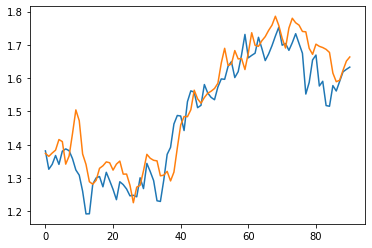

In [22]:
def regressor(tah):
    X =  df.loc[:, ['Close']].reset_index(drop='index').values[:-tah]
    y =  df.loc[:, ['Close']].reset_index(drop='index').values[tah:]

    def matrix_2d(x: np.array, timestemp: int) -> list:
        x = deepcopy(x)
        reshaped_x = []
        for i in range(timestemp, x.shape[0] + 1):
            reshaped_x.append(np.array([i[0] for i in x[i - timestemp:i]]))
        return np.array(reshaped_x)

    x_2d = matrix_2d(X[:-150], 60)
    y_ax = y[:-150][59:]

    X_train, x_test, y_train, y_test = train_test_split(x_2d, y_ax, test_size=0.33, random_state=42)
    regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
    print(regr.score(x_test, y_test))

    x_2d = matrix_2d(X[-150:], 60)
    y_ax = y[-150:][59:]

    pred = regr.predict(x_2d)

    plt.plot(y_ax)
    plt.plot(pred)

    print(regr.score(x_2d, y_ax))

regressor()

In [149]:
df_ax = pd.read_csv('../data/premodel/XOM/1-set/time_ahead_1/data/df.csv')
df_ax = df_ax.set_index('Date')
# target = pd.read_csv('../data/premodel/XOM/1-set/time_ahead_1/data/target.csv')
# df_ax['target_1'] = target['Close_Ema_5_diff'].values
# df_ax = df_ax.iloc[:-1, :]

scaler = StandardScaler()
scaler.fit(df_ax)
df_scaler = pd.DataFrame(scaler.transform(df_ax), columns=df_ax.columns, index=df_ax.index)

df['Cl'] = df_scaler['Close'].values

df

,Close,target_1,Cl
Date,,,
1973-07-16,-0.940664,-0.940664,-0.947886
1973-07-17,-0.940664,-0.941027,-0.947886
1973-07-18,-0.941027,-0.941663,-0.948249
1973-07-19,-0.941663,-0.941208,-0.948884
1973-07-20,-0.941208,-0.940845,-0.948430
...,...,...,...
2021-12-03,1.561512,1.590252,1.553349
2021-12-06,1.590252,1.618993,1.582079
2021-12-07,1.618993,1.626490,1.610808


In [143]:
df

,Open,Close,High,Low,Volume,Close_Ema_5,High_Ema_5,Low_Ema_5,Open_Ema_5,Close_Ema_9,...,momentum_ao_diff,momentum_kama_diff,momentum_roc_diff,momentum_ppo_diff,momentum_ppo_signal_diff,momentum_ppo_hist_diff,others_dr_diff,others_dlr_diff,others_cr_diff,target_1
Date,,,,,,,,,,,,,,,,,,,,,
1970-05-26,-0.907448,-0.907489,-0.908267,-0.906586,-0.855470,-0.907347,-0.908112,-0.906446,-0.907258,-0.907199,...,-0.003086,-0.034761,0.546479,0.909911,0.660788,0.807966,1.229307,1.347530,-0.008959,-0.017012
1970-05-27,-0.907433,-0.907262,-0.908117,-0.906556,-0.834368,-0.907295,-0.908079,-0.906457,-0.907291,-0.907175,...,0.001195,-0.033547,1.924326,0.987201,1.085886,0.720278,1.466207,1.557218,0.001668,-0.009411
1970-05-28,-0.907160,-0.907020,-0.907907,-0.906282,-0.671671,-0.907179,-0.907988,-0.906374,-0.907223,-0.907107,...,0.008401,-0.029916,2.056821,2.878268,2.493335,2.385013,0.042622,0.047803,0.002427,-0.006769
1970-05-29,-0.906964,-0.906839,-0.907712,-0.906160,-0.867383,-0.907042,-0.907862,-0.906277,-0.907111,-0.907017,...,0.011002,-0.027883,2.248099,-0.504371,1.710040,-1.327518,-0.452432,-0.470001,-0.000610,-0.011675
1970-06-01,-0.906783,-0.906824,-0.907712,-0.906053,-0.887465,-0.906945,-0.907778,-0.906178,-0.906977,-0.906942,...,0.014537,-0.028788,-0.138224,-0.699534,0.973248,-1.248711,-1.079579,-1.145914,-0.008959,-0.015551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-24,1.698139,1.735203,1.728972,1.720561,0.606515,1.714856,1.718658,1.701406,1.692295,1.724413,...,-2.297423,0.059111,-0.243450,-0.681238,0.402025,-0.984831,-0.900389,-0.953933,0.723963,-2.900328
2021-11-26,1.612164,1.642150,1.628366,1.592637,1.575495,1.690940,1.688864,1.665460,1.665900,1.708333,...,-3.753849,-0.497208,-2.084845,0.754299,0.747420,0.585209,-1.758139,-1.924417,-4.684333,-1.372214
2021-11-29,1.697721,1.656337,1.699577,1.666277,0.933770,1.679727,1.692747,1.666051,1.676832,1.698308,...,1.017592,-0.237324,1.155256,-0.268876,0.446228,-0.510525,1.751944,1.924783,0.703004,-3.851799


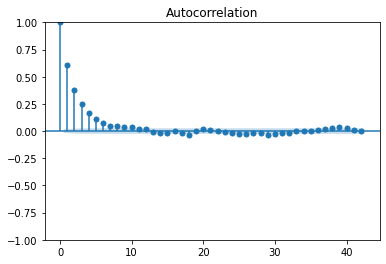

count    12993.000000
mean         0.000648
std          1.003131
min        -12.664792
25%         -0.092077
50%         -0.019866
75%          0.142560
max          7.884919
Name: Close_Ema_5_diff, dtype: float64


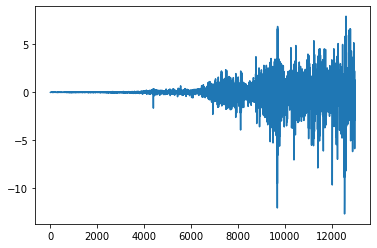

In [21]:
plot_acf(df['Close_Ema_5_diff'])
plt.show()
# print(df.corr()['Close_Ema_5_diff'].sort_values())
print(df['Close_Ema_5_diff'].describe())
# df['Close_Ema_5_diff'].hist()
plt.plot(df['Close_Ema_5_diff'].values)

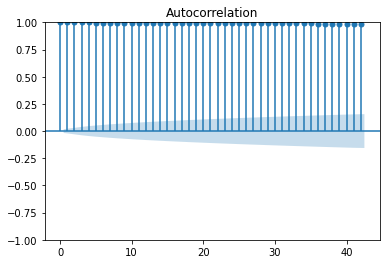

count    12993.000000
mean         0.006486
std          1.000455
min         -0.907489
25%         -0.874505
50%         -0.527235
75%          0.897540
max          2.174612
Name: Close, dtype: float64


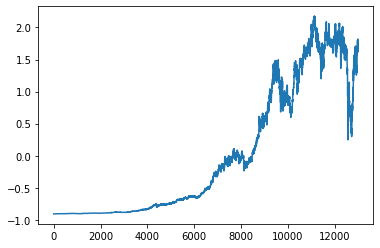

In [26]:
plot_acf(df['Close'])
plt.show()
# print(df.corr()['Close'].sort_values())
print(df['Close'].describe())
# df['Close'].hist()
plt.plot(df['Close'].values)